In [68]:
import jax
import jax.numpy as jnp
import inference.mlp as mlp
import subprocess
import inference.dataset as ds
import os
import pickle

In [71]:
c = 1
h = 30
w = 40
sizes = [512, 256]
output = 3

cfg = mlp.MLP_config(
    c = c, 
    h = h,
    w = w,
    sizes = sizes,
    output = output,
    name = "test_mult_outputs"
)

mlp.save_cfg(cfg, "weights/" + cfg.name)

key = jax.random.PRNGKey(0)

weights = mlp.qs_mlp_rgb(cfg.c, cfg.h, cfg.w, cfg.sizes, key, cfg.output)

TypeError: __init__() got an unexpected keyword argument 'output'

In [2]:
import pickle

# Specify the file path
file_path = "weights/256_256_128_54600.pkl"


cfg = mlp.read_cfg("weights/256_256_128.cfg")
key = jax.random.PRNGKey(0)
weights = mlp.get_mlp_from_cfg(cfg, key)
# Save the weights to the file
with open(file_path, "wb") as file:
    pickle.dump(weights, file)

# Load the weights from the file
with open(file_path, "rb") as file:
    loaded_weights = pickle.load(file)

# Check if the loaded weights are the same as the original weights
for i in range(len(weights)):
    for j in range(len(weights[i])):
        assert jnp.allclose(weights[i][j], loaded_weights[i][j])

Platform 'METAL' is experimental and not all JAX functionality may be correctly supported!
2024-06-01 11:49:59.404863: W pjrt_plugin/src/mps_client.cc:563] WARNING: JAX Apple GPU support is experimental and not all JAX functionality is correctly supported!


Metal device set to: Apple M2

systemMemory: 24.00 GB
maxCacheSize: 8.00 GB



In [73]:
import os
file_path = "weights/2_layer.bin"
mlp.mlp_serialize_binary(loaded_weights, file_path)
print(os.path.getsize(file_path))


4773924


In [76]:
weights = [w for w, _ in loaded_weights]
loaded_weights

AttributeError: 'list' object has no attribute 'shape'

In [5]:
#ensure file_path and "256_256_128_54600.bin" are the same
assert os.path.getsize(file_path) == os.path.getsize("weights/256_256_128_54600.bin")
#check each byte
with open(file_path, "rb") as file:
    with open("weights/256_256_128_54600.bin", "rb") as file2:
        byte = file.read(1)
        byte2 = file2.read(1)
        while byte:
            assert byte == byte2, f"ArithmeticError: {byte} != {byte2}"
            byte = file.read(1)
            byte2 = file2.read(1)

AssertionError: ArithmeticError: b'h' != b'='

In [72]:
with open('weights/256_256_50.pkl', 'rb') as file:
    loaded_weights = pickle.load(file)


In [70]:
x = jnp.zeros((2, 2201), dtype=jnp.float32).flatten()
output = mlp.mlp_forward(loaded_weights, x)
output, float_to_int(output[0])

(Array([0.00558617, 0.01505997], dtype=float32), 1001851955)

In [54]:
import struct 

def float_to_int(float_value, signed = False):
    byte_representation = struct.pack('f', float_value)
    integer_representation = struct.unpack('I', byte_representation)[0] if not signed else struct.unpack('i', byte_representation)[0]
    return integer_representation

def int_to_float(int_value):
    byte_representation = struct.pack('I', int_value)
    float_representation = struct.unpack('f', byte_representation)[0] 
    return float_representation

In [113]:
import struct

float_value = output[0]

byte_representation = struct.pack('f', float_value)
integer_representation = struct.unpack('I', byte_representation)[0]
integer_representation


1033174822

In [61]:
i = 2
img1 = jnp.array(ds.load_jpeg_image(f"debug_data/{i}.jpeg", 2201))
img2 = jnp.array(ds.load_jpeg_image(f"debug_data/{i+1}.jpeg", 2201))
data = jnp.concatenate([img1.flatten(), img2.flatten()])
output = mlp.mlp_forward(loaded_weights, data)
for o in output:
    print(float_to_int(o))
output

1096437863
0
1084454968


Array([13.6446295,  0.       ,  5.108425 ], dtype=float32)

In [67]:
# for i in img1[:10]:
#     print(float_to_int(i, signed=True))

#print a random i in img1
import random
i = random.randint(0, len(img1))
print(float_to_int(img1[i], signed=True)), i

-1087262286


(None, 689)

In [20]:
int_to_float(1100778526)

19.568416595458984

In [114]:
#now convert the integer back to float
byte_representation = struct.pack('I', integer_representation)
float_value = struct.unpack('f', byte_representation)[0]
float_value

0.07275228202342987

In [7]:
data_path = "test_data/"

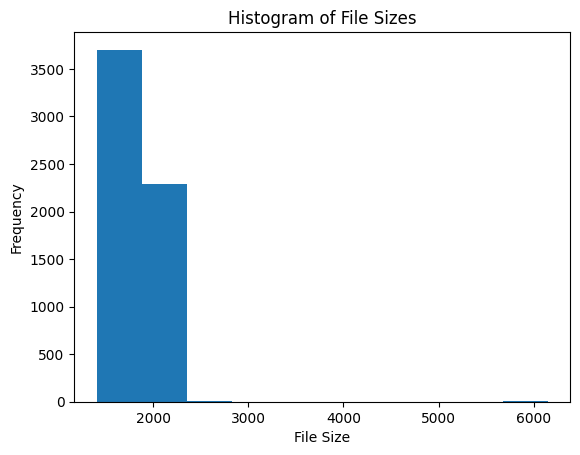

In [8]:
import os
import matplotlib.pyplot as plt

# Initialize an empty list to store the file sizes
file_sizes = []
class_file_sizes = [[], [], []]

# Iterate over the directories
for class_num in (0, 1, 2):
    class_dir = os.path.join(data_path, str(class_num))
    
    # Iterate over the files in the directory
    for file_name in os.listdir(class_dir):
        file_path = os.path.join(class_dir, file_name)
        file_size = os.path.getsize(file_path)
        file_sizes.append(file_size)
        class_file_sizes[class_num].append(file_size)

# Plot the histogram of file sizes
plt.hist(file_sizes, bins=10)
plt.xlabel('File Size')
plt.ylabel('Frequency')
plt.title('Histogram of File Sizes')
plt.show()

In [9]:
def calculate_percentage(size):
    class_counts = {class_num: 0 for class_num in (0, 1, 2)}
    for class_num in (0, 1, 2):
        for file_size in class_file_sizes[class_num]:
            if file_size <= size:
                class_counts[class_num] += 1
    return {class_num: count / len(class_file_sizes[class_num]) for class_num, count in class_counts.items()}

In [12]:
calculate_percentage(2200)

{0: 0.952023988005997, 1: 0.9995002498750625, 2: 0.9995002498750625}

In [22]:
from inference.dataset import get_jpeg_dataset
from torch.utils.data import DataLoader
dataset = get_jpeg_dataset(data_path, 3, 2201)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

Folder test_data/0 has an odd number of files
Files test_data/0/output2000.jpg and test_data/0/output2001.jpg not found
Folder test_data/1 has an odd number of files
Files test_data/1/output2000.jpg and test_data/1/output2001.jpg not found
Folder test_data/2 has an odd number of files
Files test_data/2/output2000.jpg and test_data/2/output2001.jpg not found
Dataset has 2932 samples
Dataset has 3 classes
Class 0 has 932 samples
Class 1 has 1000 samples
Class 2 has 1000 samples


In [49]:
# get a batch of data
x, y = next(iter(dataloader))
x = jnp.array(x)
print(y)
print(jnp.argmax(mlp.batch_mlp_forward(loaded_weights, x), axis=1))
mlp.batch_mlp_forward(loaded_weights, x)

tensor([1, 1, 1, 2])
[1 1 1 2]


Array([[ 0.      , 16.75191 ,  0.      ],
       [ 0.      , 18.541775,  0.      ],
       [ 0.      , 26.463055,  0.      ],
       [ 0.      ,  0.      , 19.234692]], dtype=float32)